# Risk Assessment Project Example

Here we will demonstrate how to start a new risk assessment project.
We will present the most basic steps needed.
More detailed information on each step may be found at the used tools' documentation.

We will use data loaded directly from the files directories, not using hera-data.
Information on the data available for each tool in hera-data may be found at the tools documentation.

## Demography

A new region may be cut from the source file. For example, we will use a source file of Katsrin's population,
and cut a rectangle within it.

In [1]:
from hera import toolkitHome
import pandas
import geopandas
from shapely.geometry import Polygon

projectName = "documentation"
toolkitName = "GIS_Demography"
Demography  = toolkitHome.getToolkit(projectName=projectName,toolkitName=toolkitName)

poly = Polygon([[264000,766500],[264000,767000],[264500,767000],[264500,766500]])
filePath = "../Demography/examples/Katsrin/Katsrin.shp"
KatsrinRectangle = Demography.analysis.calculatePopulationInPolygon(shapeNameOrData = poly, dataSourceOrData = filePath)
KatsrinRectangle

Loading the Building Toolkit. FreeCAD not Found, cannot convert to STL


,geometry,areaFraction,total_pop,age_0_14,age_15_19,age_20_29,age_30_64,age_65_up
0,"POLYGON ((264000.000 766500.000, 264000.000 76...",0.039139,189.229777,45.243095,13.036596,28.037974,76.201692,26.683868


The areaFraction value is the fraction of the area from the whole area of the polygon in the original data file - 
in our case, about 4 percent of the area. The population values are 4 percent of the values of the whole area.

We can also cut an area and choose to asign the population of the whole area to it. For example, if we wanted to asign the whole population of Katsrin to the selected rectangle we could do it this way:

In [2]:
KatsrinRectangle = Demography.analysis.createNewArea(shapeNameOrData=poly,dataSourceOrData=filePath).getData()
KatsrinRectangle

,geometry,total_pop,age_0_14,age_15_19,age_20_29,age_30_64,age_65_up
0,"POLYGON ((264000.000 766500.000, 264000.000 76...",4834.840687,1155.965838,333.086401,716.373196,1946.961242,681.775627


We can ask for specific population types, for example:

In [3]:
KatsrinRectangle = Demography.analysis.createNewArea(shapeNameOrData=poly,dataSourceOrData=filePath,populationTypes=["total_pop"]).getData()
KatsrinRectangle

,geometry,total_pop
0,"POLYGON ((264000.000 766500.000, 264000.000 76...",4834.840687


## LSM

Particles dispersion simulations are also needed for risk assessments.

### Loading templates

Templates may be loaded to the database using hera-lsm.
For example, for loading the v1-general template to the documentation projects the next command line should be run:

hera-LSM-load-template v1-general documentation

v1-genreal is a template for neutral conditions.

After the loading to the database, we can load a template object:

In [4]:
toolkitName = "LSM"
LSM  = toolkitHome.getToolkit(projectName=projectName,toolkitName=toolkitName)
neutralTemplate = LSM.getTemplateByName("v1-general",templateVersion="1")
neutralTemplate.params

{'TopoFile': "'INPUTFLAT'",
 'flat': '.TRUE.',
 'TopoXmin': 0.0,
 'TopoXmax': 10000.0,
 'TopoYmin': 0.0,
 'TopoYmax': 10000.0,
 'TopoXn': 500,
 'TopoYn': 500,
 'sourceRatioX': 0.1,
 'sourceRatioY': 0.5,
 'releaseTime': 1.0,
 'releaseHeight': 5,
 'windSpeed': 2,
 'windDir': 270,
 'inversionHeight': 1000,
 'savedt': 20,
 'duration': 60,
 'nParticles': 100000,
 'savedx': 10.0,
 'savedy': 10.0,
 'savedz': 10.0,
 'StationsFile': "'INPUT_STAT_DATA_HAIFA'",
 'homogeneousWind': '.TRUE.',
 'particles3D': '.FALSE.',
 'wind3D': '.FALSE.',
 'n_vdep': 0}

These are the template's default parameter; they may be changed in the simulation.

### Running a simulation

Here we will demonstrate how to run the most simple simulation, with homogenous wind over flat terrain. For more complex cases,
see the LSM tool's documentation.

The important parameters that should be considered for a homogenous flow over flat terrain are the follow:

<ul>
<li>windSpeed: The wind's speed in m/s</li>
<li>releaseHeight: The height of the release point from the ground in meters</li>
<li>inversionHeight: The inversion height in meters</li>
<li>releaseTime: The measure of the release of particles in seconds. The default is 1 second, suitable for instantaneuous release</li>
<li>savedt: The time steps used for averaging in seconds</li>
<li>nParticles: The number of particles used in the simulation</li>
<li>duration: The duration of the simulation in minutes</li>
</ul>

For example, we will run a simulation with a continuous source for 10 minutes, with wind speed of 4 m/s and time averaging of half a minute.
The default parameters presented above are used for the parameters we don't define.

In [5]:
params = dict(duration=10,windSpeed=4,releaseTime=600,savedt=30)
# neutralTemplate.run(params=params,saveMode="DB_overwrite")

### Extracting the concentration field

The concentration field may be eatracted from a simulation.

The simulation may be loaded from the database:

In [6]:
simulation = LSM.getSimulations(**params)[0]

Alternatively, it may be loaded directely from the file:

In [7]:
LSM.singleSimulation(resource="/home/eyal/Development/Hera/hera/doc/source/toolkits/riskAssessment/6072ef11bb31a0a7a6c9bb1c/netcdf")

Then, the concentration field may be calculated. We may deliver the total mass of particles dispersed; the default is 1 kg.

In [8]:
from unum.units import *
Concentration = simulation.getConcentration(Q=10*kg)
Concentration

<xarray.Dataset>
Dimensions:   (datetime: 20, x: 1000, y: 1000, z: 1)
Coordinates:
  * x         (x) float64 -995.0 -985.0 -975.0 ... 8.975e+03 8.985e+03 8.995e+03
  * z         (z) float64 0.0
  * y         (y) float64 -4.995e+03 -4.985e+03 ... 4.985e+03 4.995e+03
  * datetime  (datetime) datetime64[ns] 2016-01-01T12:00:30 ... 2016-01-01T12:10:00
Data variables:
    dDosage   (datetime, y, x, z) float64 dask.array<chunksize=(20, 1000, 1000, 1), meta=np.ndarray>
    C         (datetime, y, x, z) float64 dask.array<chunksize=(20, 1000, 1000, 1), meta=np.ndarray>
Attributes:
    dt:       0.5 [min]
    Q:        10000000.0 [mg]
    C:        1.0 [mg/m3]

## Assessing the effect

In order to assess the effect of the dispersion, we first need to get an agent.

### Loading and retrieving an agent

An agent may be loaded to the database using a dictionary or json file with its description. For example, we will load a json file.

In [9]:
risk = toolkitHome.getToolkit(toolkitName="RiskAssessment", projectName = projectName)

risk.loadData(fileNameOrData="/home/eyal/Development/Hera/hera/doc/source/toolkits/riskAssessment/ExampleAgent.json",saveMode="DB_overwrite")

<Measurements: Measurements object>

The agent may be retrieved using its name, defined in the json file.

In [10]:
Agent = risk.getAgent("ExampleAgent")

### Calculating the effect

The main use of the agent object is to calculate the dimensions of the affected areas for the different injury levels of the different injury types.
This is done simply using the "calculate" function, that should receive a concentration field and the name of the appropiate field in the concentration xarray.

If we are interested only in the effect at the end of the event, which is often the case, we can set the isel parameter to choose the final time step.
Otherwise, we don't deliver a value for isel, and we get the effect in each time step.

In [11]:
riskAreas = Agent.RegularPopulation.calculate(Concentration, "C", isel={"datetime":-1})
riskAreas[:10]

,ToxicLoad,TotalPolygon,severity,datetime,percentEffected,ThresholdPolygon
0,1.505127,"MULTIPOLYGON (((185.000 55.543, 192.118 57.882...",Severe,2016-01-01 12:10:00,0.05,"(POLYGON ((185 55.54308732884635, 192.11834167..."
1,2.286779,"POLYGON ((235.000 -54.996, 234.996 -54.996, 22...",Severe,2016-01-01 12:10:00,0.10,"POLYGON ((235 -54.99633231068524, 234.99638495..."
2,3.032378,"POLYGON ((235.000 -51.679, 231.726 -51.726, 22...",Severe,2016-01-01 12:10:00,0.15,"POLYGON ((235 -51.67878397548793, 231.72645137..."
3,3.794804,"POLYGON ((235.000 -48.286, 228.383 -48.383, 22...",Severe,2016-01-01 12:10:00,0.20,"POLYGON ((235 -48.28635994499737, 228.38271675..."
4,4.599971,"POLYGON ((225.000 -44.920, 220.792 -45.000, 21...",Severe,2016-01-01 12:10:00,0.25,"POLYGON ((225 -44.91980021759564, 220.79189929..."
5,5.467638,"POLYGON ((216.983 -43.017, 215.000 -43.376, 20...",Severe,2016-01-01 12:10:00,0.30,POLYGON ((216.9830263246679 -43.01697367533211...
6,6.417114,"POLYGON ((219.276 -40.724, 215.000 -41.499, 20...",Severe,2016-01-01 12:10:00,0.35,POLYGON ((219.2761655872956 -40.72383441270438...
7,7.470101,"POLYGON ((221.819 -38.181, 215.000 -39.417, 21...",Severe,2016-01-01 12:10:00,0.40,"POLYGON ((221.8192984906041 -38.1807015093959,..."
8,8.653052,"POLYGON ((224.676 -35.324, 215.000 -37.078, 21...",Severe,2016-01-01 12:10:00,0.45,POLYGON ((224.6763186975875 -35.32368130241245...
9,10.000000,"POLYGON ((18.988 18.988, 25.000 23.355, 26.053...",Severe,2016-01-01 12:10:00,0.50,"POLYGON ((18.98758512671143 18.98758512671143,..."


The risk areas calculated may be projected the demography.
For example, we will release the agent near the rectangle we cut from Katsrin.

In [12]:
windAngle = 0
x_coordinate = 263750
y_coordinate = 766750
injuryareas = riskAreas.project(KatsrinRectangle, loc=[x_coordinate,y_coordinate],mathematical_angle=windAngle)
injuryareas[:10]

/raid/opt/anaconda3/envs/Math-20-05/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,geometry,areaFraction,total_pop,effectedtotal_pop,percentEffected,ToxicLoad,severity,datetime
0,"MULTIPOLYGON (((264000.000 766661.694, 264000....",0.035298,170.662474,8.510294,0.049866,0.150513,Light,2016-01-01 12:10:00
0,"MULTIPOLYGON (((264000.000 766666.393, 264000....",0.024229,117.144792,11.654010,0.099484,0.228678,Light,2016-01-01 12:10:00
0,"MULTIPOLYGON (((264000.000 766670.530, 264000....",0.022074,106.724177,15.880880,0.148803,0.303238,Light,2016-01-01 12:10:00
0,"MULTIPOLYGON (((264000.000 766673.840, 264000....",0.023537,113.797270,22.504066,0.197756,0.379480,Light,2016-01-01 12:10:00
0,"MULTIPOLYGON (((264000.000 766675.953, 264000....",0.018290,88.430843,21.776789,0.246258,0.459997,Light,2016-01-01 12:10:00
0,"MULTIPOLYGON (((264000.000 766677.489, 264000....",0.014229,68.794142,20.239595,0.294205,0.546764,Light,2016-01-01 12:10:00
0,"MULTIPOLYGON (((264000.000 766679.170, 264000....",0.013804,66.741549,22.790095,0.341468,0.641711,Light,2016-01-01 12:10:00
0,"MULTIPOLYGON (((264000.000 766680.839, 264000....",0.014011,67.742833,26.276183,0.387881,0.747010,Light,2016-01-01 12:10:00
0,"MULTIPOLYGON (((264000.000 766682.538, 264000....",0.017644,85.305917,36.957446,0.433234,0.865305,Light,2016-01-01 12:10:00
0,"MULTIPOLYGON (((264000.000 766684.472, 264000....",0.020480,99.017309,47.255998,0.477250,1.000000,Light,2016-01-01 12:10:00


## Presentation

The injuryareas parameter is a geodataframe with polygons that correspond to injury severities,
with the number of injured population in each polygon.
Using this data, one may design and present one's risk assessment as one desires.
For example, one may get the total number of injuries in each severity this way:

In [13]:
totalInjuries = injuryareas.groupby("severity")["effectedtotal_pop"].sum()
totalInjuries

severity
Light     946.328928
Severe    198.468724
Name: effectedtotal_pop, dtype: float64

One may also use built-in plots of the riskassessment tool.
At the moment, one plot type is available,
which shows the risk areas polygons.

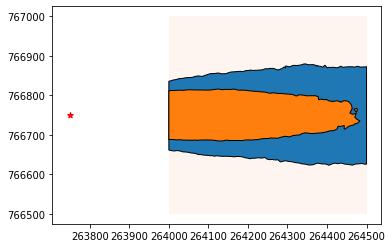

In [14]:
import matplotlib.pyplot as plt
ax, retProj = risk.presentation.plotCasualtiesProjection(results=riskAreas,area=KatsrinRectangle,loc=[x_coordinate,y_coordinate],
                                             mathematical_angle=windAngle, severityList=["Light","Severe"],
                                                            cycler=plt.cycler(fc=plt.rcParams['axes.prop_cycle'].by_key()['color'])*plt.cycler(ec=['black']))
KatsrinRectangle.plot(ax=ax,cmap='Reds')
ax.scatter(x_coordinate,y_coordinate,marker="*",color="red")
ax